## Imports

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, ks_2samp

## Input

In [86]:
PROJECTDIR = Path('.').resolve().parents[2]
lossfam_path = f'{PROJECTDIR}/external_data/all_rodentlost_mirfams.list'
# mirgenedb 3.0
# expression_path = '../data/hsa-tissueItems.txt'
# mirgenedb 2.1
expression_path = '/share/project/felixl/MirGeneDB/2.1/hsa_expressionPerTissue.txt'
OUTPATH = f'{PROJECTDIR}/publication/supplement_figures/coexpression_mirgenedb21.png'

## Variables

In [87]:
binary = True
binary_read_cutoff = 15
metric = 'euclidean'

## Functions

In [88]:
def mirna2mirfam(mirna):
    return '-'.join(mirna.split('-')[1:3]).split('_')[0]


def parse_data(path):
    df = pd.read_csv(path)
    #filter out knockout tissues
    df = df.loc[:, ~df.columns.str.contains("knockout")]
    df['mirfam'] = df['Gene name'].apply(mirna2mirfam)
    
    # fill NaN values with 0
    
    # take hightes read count of miRNA in family
    fdf = df.drop(columns=['Gene name'])
    fdf = fdf.groupby(['mirfam']).max()
    return fdf


def binarize_table(df, cutoff):
    return df.map(lambda x: 1 if x > cutoff else 0)   



def calculate_vector_distance(df, metric):
    distances = pdist(df.values, metric)

    return distances


def random_samples(df, samplesize, metric, iterations=10000):
    sample_distances = []
    for i in range(iterations):
        sample = df.sample(n=samplesize)
        sample_distances.extend(calculate_vector_distance(sample, metric))
        
    df = pd.DataFrame(sample_distances, columns=['distance'])
    df['type'] = 'background'
    return df


def lost_distance(df, metric):
    distance = calculate_vector_distance(df, metric)
    df = pd.DataFrame(distance, columns=['distance'])
    df['type'] = 'sample'
    return df


def load_mirnas(path):
    with open(path) as fh:
        lostfams = [line.strip() for line in fh if line]
    # Mir-2277 not in MirGeneDB 2.1 anymore
    lostfams.remove('Mir-2277')
    return lostfams
    
    
def permutation_test(sample, random_samples, n_permutations=10000):
    observed_stat = np.abs(np.mean(sample) - np.mean(random_samples))
    combined = np.concatenate([sample, random_samples])
    count = 0
    
    # Perform permutations
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_sample = combined[:len(sample)]
        perm_random_samples = combined[len(sample):]
        perm_stat = np.abs(np.mean(perm_sample) - np.mean(perm_random_samples))
        if perm_stat >= observed_stat:
            count += 1

    p_value = count / n_permutations
    return p_value


## Main function

In [93]:
def mirna_tissue_coexpression(path, binary, binary_read_cutoff, metric):
    # all miRNAs
    expdf = parse_data(path)
    binary_expdf = binarize_table(expdf, binary_read_cutoff)

    # lost miRNAs
    lostfams = load_mirnas(lossfam_path)
    lost_binary_expdf = binary_expdf.loc[lostfams]
    lost_expdf = expdf.loc[lostfams]
    
    # visualize input
    fig = px.imshow(lost_expdf, zmax=50, title='Normalized Reads (capped at 50)')
    fig.show()
    if binary:
        fig = px.imshow(lost_binary_expdf, title=f'Binary representation (threshold={binary_read_cutoff})')
        fig.show()
        
    # calculate distances
    if binary:
        random_distances = random_samples(binary_expdf, samplesize=len(lostfams), metric=metric)
        lost_distances = lost_distance(lost_binary_expdf, metric)
    else:
        random_distances = random_samples(expdf, samplesize=len(lostfams), metric=metric)
        lost_distances = lost_distance(lost_expdf, metric)
        

    # statistical tests
    ks_stat, ks_p = ks_2samp(random_distances.distance.values, lost_distances.distance.values)
    u_stat, u_p = mannwhitneyu(random_distances.distance.values, lost_distances.distance.values)

    print('Test whether the two distributions have different shapes')
    print(f"Kolmogorov-Smirnov test p-value: {ks_p}")
    print('')
    print('Test whether the two distributions have different medians')
    print(f'Mann-Whitney U Test p-value: {u_p}')
    print('')
    
    # permutation test takes couple of minutes
    permutation = False
    if permutation:
        permutation_p = permutation_test(random_distances.distance.values, lost_distances.distance.values)
        print('Permutation test')
        print(f"Permutation test p-value: {permutation_p}")
    
    
    # plot
    sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='white')
    sns.histplot(data=random_distances, x='distance', stat='density', alpha=0.1, element="step", color='grey', bins=10, label='background')
    sns.histplot(data=lost_distances, x='distance', stat='density', alpha=0.5, bins=10, element="step", label='lost_miRNAs')
    
    plt.axvline(x=np.median(random_distances.distance.values), color='darkgrey', linestyle='--', linewidth=5, label='median_background')
    plt.axvline(x=np.median(lost_distances.distance.values), color='tab:blue', linestyle='-', linewidth=1, label='median_lost_miRNAs')
    
    plt.xlabel(f'{metric} distance')
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPATH, dpi=600)
    plt.show()



## Output

Test whether the two distributions have different shapes
Kolmogorov-Smirnov test p-value: 0.06069022944978642

Test whether the two distributions have different medians
Mann-Whitney U Test p-value: 0.6685068145012845



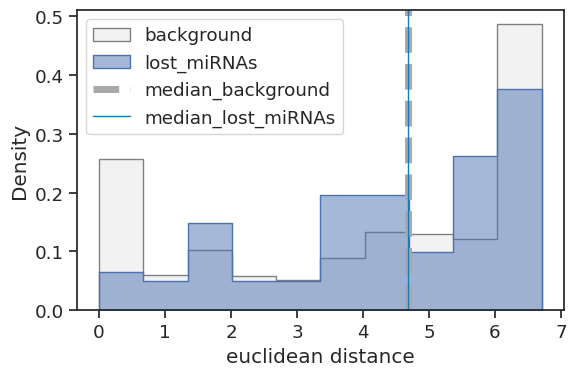

In [94]:
mirna_tissue_coexpression(expression_path, binary, binary_read_cutoff, metric)